In [3]:
from collections import namedtuple

import pandas as pd
import numpy as np

import pytorch_lightning as pl

import tqdm
import json
import sklearn.metrics as sm

# import tensorboardX as tb
import tensorflow as tf
import datetime, os

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(31337)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

## Create pairs (first track, subsequent track, time)

In [5]:
DATA_DIR = '/home/tatiana/Downloads/' # MADE_Ubuntu/MADE_2/RecSys/recsys-itmo-spring-2023/botify/data'

In [4]:
data = pd.read_json(DATA_DIR + "data_seminar_04.json", lines=True)

In [5]:
print(len(data))
data.head(5)

815255


,message,timestamp,user,track,time,latency,recommendation,experiments
0,last,2022-06-13 11:39:37.645,4013,18934,0.02,0.000206,NaN,"{'AA': 'T1', 'COLLABORATIVE': 'T1'}"
1,next,2022-06-13 11:39:37.683,9693,29738,1.00,0.000902,3079.0,"{'AA': 'C', 'COLLABORATIVE': 'C'}"
2,next,2022-06-13 11:39:37.692,9693,3079,0.06,0.000923,20078.0,"{'AA': 'C', 'COLLABORATIVE': 'C'}"
3,next,2022-06-13 11:39:37.700,9693,20078,1.00,0.000858,12044.0,"{'AA': 'C', 'COLLABORATIVE': 'C'}"
4,next,2022-06-13 11:39:37.708,9693,12044,0.00,0.000927,37424.0,"{'AA': 'C', 'COLLABORATIVE': 'C'}"


In [6]:
data[(data['user'] == 4013)].sort_values(by='timestamp').head(10) # &(data['track'] == 8399)]

,message,timestamp,user,track,time,latency,recommendation,experiments
364224,next,2022-06-13 10:00:51.357,4013,8399,1.00,0.000983,4179.0,"{'AA': 'T1', 'COLLABORATIVE': 'T1'}"
364225,next,2022-06-13 10:00:51.372,4013,4179,0.28,0.000985,8058.0,"{'AA': 'T1', 'COLLABORATIVE': 'T1'}"
364226,next,2022-06-13 10:00:51.382,4013,8058,0.97,0.000880,3803.0,"{'AA': 'T1', 'COLLABORATIVE': 'T1'}"
364227,next,2022-06-13 10:00:51.392,4013,3803,0.00,0.000914,26872.0,"{'AA': 'T1', 'COLLABORATIVE': 'T1'}"
364228,next,2022-06-13 10:00:51.401,4013,26872,0.00,0.000856,42043.0,"{'AA': 'T1', 'COLLABORATIVE': 'T1'}"
364229,next,2022-06-13 10:00:51.410,4013,42043,0.00,0.001013,9488.0,"{'AA': 'T1', 'COLLABORATIVE': 'T1'}"
364230,next,2022-06-13 10:00:51.421,4013,9488,0.01,0.000909,14105.0,"{'AA': 'T1', 'COLLABORATIVE': 'T1'}"
364231,last,2022-06-13 10:00:51.429,4013,14105,0.00,0.000210,NaN,"{'AA': 'T1', 'COLLABORATIVE': 'T1'}"
443784,next,2022-06-13 10:22:51.585,4013,19969,1.00,0.000984,14107.0,"{'AA': 'T1', 'COLLABORATIVE': 'T1'}"
443785,next,2022-06-13 10:22:51.594,4013,14107,0.00,0.000930,190.0,"{'AA': 'T1', 'COLLABORATIVE': 'T1'}"


In [7]:
np.unique(data['user']).shape

(10000,)

In [8]:
Pair = namedtuple("Session", ["user", "start", "track", "time"])

def get_pairs(user_data):
    pairs = []
    first = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if first is None:
            first = row["track"]
        else:
            pairs.append(Pair(row["user"], first, row["track"], row["time"]))
        
        if row["message"] == "last":
            first = None
    return pairs

In [9]:
pairs = pd.DataFrame(
    data
    .groupby("user")
    .apply(get_pairs)
    .explode()
    .values
    .tolist(),
    columns=["user", "start", "track", "time"]
)

In [10]:
pairs[(pairs['user'] == 4013)&(pairs['start']==8399)]

,user,start,track,time
285420,4013,8399,4179,0.28
285421,4013,8399,8058,0.97
285422,4013,8399,3803,0.00
285423,4013,8399,26872,0.00
285424,4013,8399,42043,0.00
285425,4013,8399,9488,0.01
285426,4013,8399,14105,0.00


In [11]:
pairs.groupby(['start']).value_counts() #count()

start  user  track  time
0      1625  5737   0.00    2
             4913   0.00    1
             16293  0.00    1
             17273  0.00    1
7      5330  2854   0.34    2
                           ..
49999  6815  23067  0.91    1
             31095  0.67    1
             32413  0.82    1
             36807  1.00    1
             49431  0.96    1
Length: 700776, dtype: int64

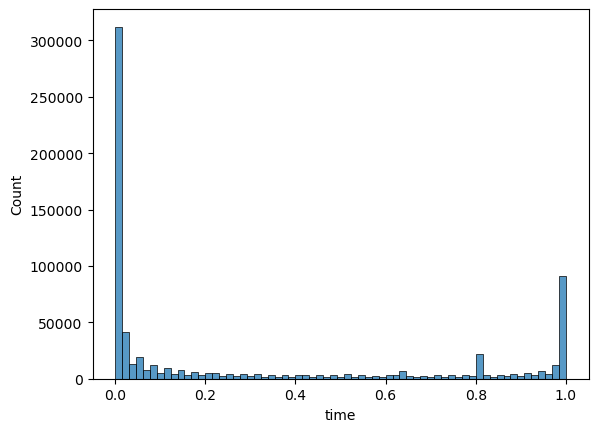

In [12]:
figure, ax = plt.subplots()
sns.histplot(pairs["time"], ax=ax)
pass

## Train Model

In [13]:
rdm = np.random.random(len(pairs))
train_data = pairs[rdm < 0.8]
val_data = pairs[(rdm >= 0.8) & (rdm < 0.9)]
test_data = pairs[rdm >= 0.9]

len(train_data), len(val_data), len(test_data)

(572587, 70915, 71742)

In [16]:
context = nn.Embedding(num_embeddings=50000, embedding_dim=10)
context(x[:, 0]) 

NameError: name 'x' is not defined

In [ ]:
class ContextualRanker(pl.LightningModule):
    def __init__(self, embedding_dim=10):
        super().__init__()
        self.embedding_dim = embedding_dim
        
        # We won't have embeddings for everything, but that's ok
        self.context = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)
        self.track = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)

    def forward(self, x):
        context = self.context(x[:, 0]) # start track
        track = self.track(x[:, 1]) # next track
        return torch.sum(context * track, dim=1)
            
    def step(self, batch, batch_idx, metric, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        loss = F.mse_loss(predictions, y.float(), reduction='mean')
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def test_step(self, batch, batch_idx, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        targets = y[:, 0].float()
        avgs = y[:, 1].float()
        rdms = y[:, 2].float()

        loss = F.mse_loss(predictions, targets, reduction='mean')
        avg_loss = F.mse_loss(avgs, targets, reduction='mean')
        rdm_loss = F.mse_loss(rdms, targets, reduction='mean')

        self.log("test_loss", loss, prog_bar=prog_bar)
        self.log("avg_loss", avg_loss, prog_bar=prog_bar)
        self.log("rdm_loss", rdm_loss, prog_bar=prog_bar)

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train_loss")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val_loss", True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'reduce_on_plateau': True,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

In [ ]:
class ContextualRankerData(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_data, features):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.features = features

    def prepare_data(self):
        self.test_data = self.test_data.assign(rdm = np.random.random(len(self.test_data))).assign(avg = self.train_data["time"].mean())

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
        self.train_dataset = td.TensorDataset(
            torch.from_numpy(self.train_data[self.features].values), 
            torch.from_numpy(self.train_data["time"].values)
            )

        self.val_dataset = td.TensorDataset(
            torch.from_numpy(self.val_data[self.features].values), 
            torch.from_numpy(self.val_data["time"].values)
            )

        if stage == "test" or stage is None:  
        self.test_dataset = td.TensorDataset(
            torch.from_numpy(self.test_data[self.features].values),
            torch.from_numpy(self.test_data[["time", "avg", "rdm"]].values)
        )
    def train_dataloader(self):
        return td.DataLoader(self.train_dataset, batch_size=2048, shuffle=True, num_workers=0)

    def val_dataloader(self):
        return td.DataLoader(self.val_dataset, batch_size=2048, num_workers=0)

    def test_dataloader(self):
        return td.DataLoader(self.test_dataset, batch_size=512, shuffle=False, num_workers=0)

In [ ]:
net = ContextualRanker(embedding_dim=100)
data_module = ContextualRankerData(train_data, val_data, test_data, features = ["start", "track"])

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(
    max_epochs=300,
    accelerator='gpu', 
    devices=1,
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=5),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback
    ])

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs --host localhost

In [ ]:
trainer.fit(
    net, 
    data_module
)

In [ ]:
best = ContextualRanker.load_from_checkpoint(checkpoint_callback.best_model_path, embedding_dim=100)

In [ ]:
trainer.test(best, data_module)

## Compute top recommendations

In [ ]:
track_meta = pd.read_json(DATA_DIR + "tracks.json", lines=True)

In [ ]:
context_embeddings = dict(best.named_parameters())["context.weight"].data.cpu().numpy()
track_embeddings = dict(best.named_parameters())["track.weight"].data.cpu().numpy()

In [ ]:
track_meta.head()

In [ ]:
k = 100
with open(DATA_DIR + "tracks_with_recs.json", "w") as rf:
    for _, track in tqdm.tqdm(track_meta.iterrows()):
        embedding = context_embeddings[track["track"]]
        neighbours = np.argpartition(-np.dot(track_embeddings, embedding), k)[:k]
        
        recommendation = dict(track)
        recommendation["recommendations"] = neighbours.tolist()
        
        rf.write(json.dumps(recommendation) + "\n")

In [ ]:
track = 3916
embedding = context_embeddings[track]
track_meta.loc[track_meta["track"] == track, ["artist", "title"]]

In [ ]:
k = 10
neighbours = np.argpartition(-np.dot(track_embeddings, embedding), k)[:k]
track_meta.loc[track_meta["track"].isin(neighbours), ["artist", "title"]]